In [1]:
# PERM

import random
import numpy as np

def PERM(L, C_plus = 10, C_minus = 1):
    """
    Generates a self-avoiding walk (SAW) of length L using PERM.

    The walk starts at the origin (0,0). At each step, valid moves are determined by ensuring no self-intersection.
    The weight of a partial configuration is updated as the product of valid moves at each step.
    Paths with weights below the pruning threshold are discarded with probability 0.5; surviving paths have their weight doubled.
    Paths with weights above the enrichment threshold are split into multiple copies, each with reduced weight.
    Completed walks contribute to the total weight estimate.
    If L = 0, the function returns 1 directly as there is only one trivial walk of length 0.
    The algorithm uses a stack to manage partial configurations.

    Returns:
        total_weights[L] (float): One value for the PERM estimate of c_L.
    """
    # Special case: L = 0
    if L == 0:
        return 1

    # Thresholds
    Z_hat = [1] * (L + 1)  # Z_hat[i] is the estimate of Z for length i, initialised to 1 for all i in [0, L]

    def W_plus(n):
        return C_plus * Z_hat[n]
    
    def W_minus(n):
        return C_minus * Z_hat[n]

    # Initialise a stack: (path, path set, total weight, total walks)
    stack = [([(0,0)], {(0,0)}, 1, 0)]  # Start at the origin with weight 1 and length 0
    total_weights = np.zeros(L + 1)  # Stores the total weight of each length, initialised to 0
    total_walks = np.zeros(L + 1)  # Stores the total number of walks of each length, initialised to 0

    while stack:
        # Pop the last item from the stack
        path, path_set, weight, n = stack.pop()
        if n == L: # Reached the target length
            continue
        
        # Not reached the target length yet, so we need to generate valid moves
        last_pos = path[-1] # Get the last position in the path
        valid_moves = []
        for dx, dy in [(1,0), (-1,0), (0,1), (0,-1)]: # Possible moves (Right, Left, Up, Down)
            # Check if the new position is valid (not visited)
            new_pos = (last_pos[0] + dx, last_pos[1] + dy)
            if new_pos not in path_set:
                valid_moves.append(new_pos)
        w_n = len(valid_moves) # Number of valid moves
        if w_n == 0:
            continue  # Attrition, move to next iteration
        
        # Valid moves is not 0, update weight
        new_weight = weight * w_n
        move = random.choice(valid_moves)  # Randomly select a move from the valid moves
        new_path = path + [move]  # Add the new move to the path
        new_path_set = set(path_set)
        new_path_set.add(move)
        new_n = n+1

        # Pruning/enrichment
        if new_weight < W_minus(new_n):
            # Weight too low, prune with probability 0.5
            if np.random.rand() < 0.5:
                continue  # Prune and move to the next iteration
            else:
                new_weight *= 2 # Survives pruning, balance out the weight of pruned paths
        elif new_weight > W_plus(new_n): # Good path, enrich it
            k = 2 # Total number of copies
            for _ in range(k):
                stack.append((new_path, new_path_set, new_weight / k, new_n)) # Add the new path to the stack k times
                # Update Z_hat (partition sum) for both copies
                total_walks[new_n] += 1
                total_weights[new_n] += new_weight / k
                Z_hat[new_n] = total_weights[new_n] / total_walks[new_n] if total_walks[new_n] > 0 else 0
            continue
        
        # Didn't prune or enrich, just add the new path to the stack
        stack.append((new_path, new_path_set, new_weight, new_n))
        # Update Z_hat
        total_walks[new_n] += 1
        total_weights[new_n] += float(new_weight)
        Z_hat[n+1] = total_weights[new_n] / total_walks[new_n] if total_walks[new_n] > 0 else 0
    
    return total_weights[L]

In [2]:
# Compute Monte Carlo estimates for c_L for L = 0 to 10 using 100,000 samples per length
for i in range(1,11):
    samples = [PERM(i) for _ in range(100000)]
    print(f"Estimated c_{i}: {np.mean(samples)}")

Estimated c_1: 4.0
Estimated c_2: 12.0
Estimated c_3: 36.0
Estimated c_4: 100.00512
Estimated c_5: 283.96926
Estimated c_6: 780.243705
Estimated c_7: 2170.2178125
Estimated c_8: 5916.2543775
Estimated c_9: 16292.143625625
Estimated c_10: 44110.097656875


In [ ]:
# Estimate c_L up to L = 700 and plot the graph of mu estimate against L
# c_L approximates mu^L, mu hat = c_L^(1/L)

L_values = list(np.arange(1, 51))
L_values.extend(list(np.arange(100, 701, 100)))

mu_hats = []

# 10,000 samples for each L value (takes too long for 100,000)
for L in L_values:
    samples = [PERM(L, C_plus=50, C_minus=5) for _ in range(10000)]
    cL_hat = np.mean(samples)
    mu_hats.append(cL_hat**(1/L))

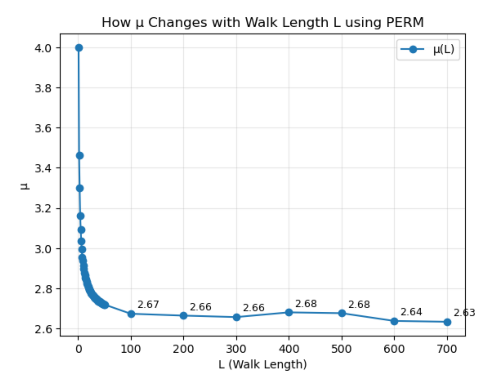

In [ ]:
# Plot the results
import matplotlib.pyplot as plt

# plot mu_hats against L
plt.figure(figsize=(8, 5))
plt.plot(L_values, mu_hats, marker='o', linestyle='-', label = 'μ(L)')
plt.xlabel('L (Walk Length)')
plt.ylabel('μ')
plt.title('How μ changes with Walk Length L using PERM')

# add annotations for each point from L=100 onwards
for i in range(len(L_values)-7, len(L_values)):
    plt.annotate(f'{mu_hats[i]:.2f}', 
                 xy=(L_values[i], mu_hats[i]),
                 xytext=(5, 5), 
                 textcoords='offset points',
                 fontsize=9
                )
    
plt.grid()
plt.legend()
plt.show()